In [1]:
from emocon.datasets import load_video_dataloaders, investigate_video, display_gif
from emocon.models.model_utils import load_mae_simCLR_model
import torch

In [2]:
train, test, dev = load_video_dataloaders()
i, item = next(enumerate(train))


video torch.Size([3, 16, 224, 224])
video_name dia622_utt6.mp4
video_index 6178
clip_index 0
aug_index 0
label 4
Video label: anger


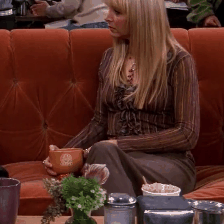

In [3]:
investigate_video(item)
display_gif(item['video'])


In [4]:
model_name = "./videomae-base-finetuned-meld/checkpoint-4069/"
model = load_mae_simCLR_model(model_name=model_name, num_labels=7)

In [5]:
def collate_fn(examples):
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

inputs = collate_fn([item, item])
inputs['pixel_values']
inputs['labels']

tensor([4, 4])

In [6]:
out = model(**inputs)

In [7]:
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error as mse
from emocon.trainer import ContrastiveTrainer
from transformers import TrainingArguments

In [8]:

model_name = "contastive-vmae"
num_epochs = 11
batch_size = 4

args = TrainingArguments(
    model_name,
    label_names='labels',
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1_score",
    max_steps= (train.num_videos // batch_size) * num_epochs,
    save_total_limit =3,
)

trainer = ContrastiveTrainer(
    model=model,
    args=args,
    train_dataset=train,
    eval_dataset=dev,
    data_collator=collate_fn,
    compute_metrics= lambda pred: {
        "accuracy": accuracy_score(pred.label_ids, pred.predictions[0].argmax(-1)),
        "f1_score": f1_score(pred.label_ids, pred.predictions[0].argmax(-1), average='weighted')
    },
)

/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [9]:
trainer.train()

/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
0,1.602100,No log,0.372185,0.266185
1,1.485000,No log,0.405960,0.263668
2,1.459200,No log,0.413245,0.241673
3,1.455100,No log,0.413907,0.253048
4,1.499100,No log,0.405960,0.257000
5,1.498700,No log,0.405298,0.273575
6,1.416200,No log,0.409272,0.262019
7,1.414700,No log,0.411921,0.264946
8,1.325200,No log,0.379470,0.286592
9,1.255200,No log,0.370199,0.273340


/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along

TrainOutput(global_step=27467, training_loss=0.910046213243996, metrics={'train_runtime': 232048.5554, 'train_samples_per_second': 1.894, 'train_steps_per_second': 0.118, 'total_flos': 0.0, 'train_loss': 0.910046213243996, 'epoch': 31.03})

: 